In [1]:
import zipfile
import pandas as pd
import numpy as np
from datetime import datetime

# bokeh libraries
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, output_file
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool, Legend, HoverTool
from bokeh.plotting import figure, show

#set rendering to notebook
output_notebook()

#uncomment the following two lines if you get an SSL error when downloading the data
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

path = "https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/daggegevens/etmgeg_260.zip"
df = pd.read_csv(path,compression='zip', skiprows=51, low_memory=False)
df.head()

Loading BokehJS ...

,# STN,YYYYMMDD,DDVEC,FHVEC,FG,FHX,FHXH,FHN,FHNH,FXX,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,EV24
0,260,19010101,,,,,,,,,...,,,,,66,,,,,
1,260,19010102,,,,,,,,,...,,,,,86,,,,,
2,260,19010103,,,,,,,,,...,,,,,89,,,,,
3,260,19010104,,,,,,,,,...,,,,,79,,,,,
4,260,19010105,,,,,,,,,...,,,,,65,,,,,


In [2]:
def preprocess(df):
    """
    preprocess 'de bilt etmaalgegevens' for analysis
    
    parameters: raw dataframe
    returns: cleaned dataframe
    
    """
    #FG = Etmaalgemiddelde windsnelheid (in 0.1 m/s) 
    #TG = Etmaalgemiddelde temperatuur (in 0.1 graden Celsius) 
    #YYYYMMDD = timestamp
    
    threshold_value = -6.5  

    df = df.rename(columns={"YYYYMMDD": "date", "   TG": "temperature", "   FG": "velosity"}, 
              errors="raise")
    df = df[['date', 'temperature', 'velosity']]
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='coerce')
    df['temperature'] = df['temperature'].astype('float64')
    df['velosity'] = pd.to_numeric(df['velosity'], errors='coerce')
    df.temperature = df.temperature/10
    df.velosity = df.velosity/10
   
    df.set_index('date', inplace=True)     
    return df

In [3]:
df = preprocess(df)

In [4]:
df.head()

,temperature,velosity
date,,
1901-01-01,-4.9,NaN
1901-01-02,-1.8,NaN
1901-01-03,-2.6,NaN
1901-01-04,-6.5,NaN
1901-01-05,-6.0,NaN


In [5]:
print(plt.style.available)
plt.style.use('dark_background')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


When you set the datetimestamp as index you can slice date series of interest

In [6]:
subset = df['2000':'2024']
subset

,temperature,velosity
date,,
2000-01-01,6.1,2.5
2000-01-02,7.3,3.7
2000-01-03,8.4,6.1
2000-01-04,6.4,3.8
2000-01-05,4.4,4.0
...,...,...
2024-02-06,10.6,7.9
2024-02-07,4.1,1.5
2024-02-08,2.8,2.9


In [7]:
subset = df['2000-01-01':'2024-01-01']
subset

,temperature,velosity
date,,
2000-01-01,6.1,2.5
2000-01-02,7.3,3.7
2000-01-03,8.4,6.1
2000-01-04,6.4,3.8
2000-01-05,4.4,4.0
...,...,...
2023-12-28,10.9,8.1
2023-12-29,9.3,6.0
2023-12-30,8.1,4.2


In [8]:
df.velosity = df.velosity/10

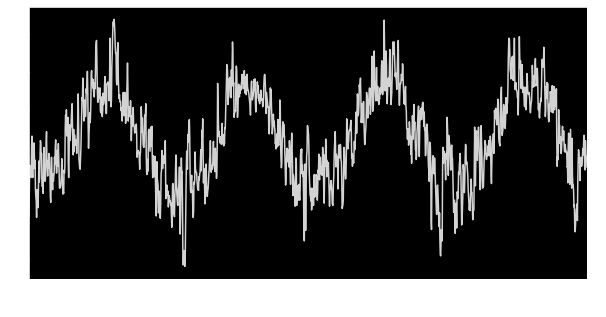

In [9]:
sub = df['2020-01-01':'2024-01-01']
sub['temperature'].plot(color='lightgrey', figsize=(10, 5))
plt.savefig('weather_raw.png')

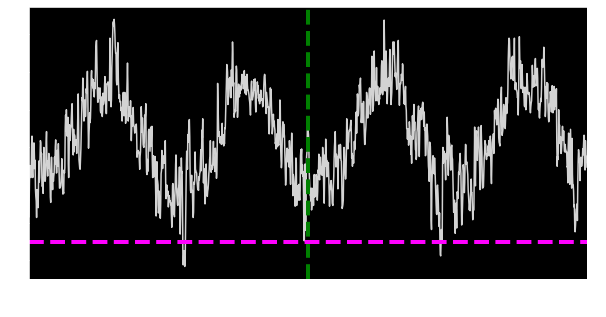

In [10]:
ax = sub['temperature'].plot(color='lightgrey', figsize=(10, 5))
# Add a vertical line
ax.axvline('2022-01-01', color='green', linestyle='--', linewidth=4)
# Add a horizontal line
ax.axhline(-2.5, color='magenta', linestyle='--', linewidth=4)
plt.savefig('weather_lines.png')

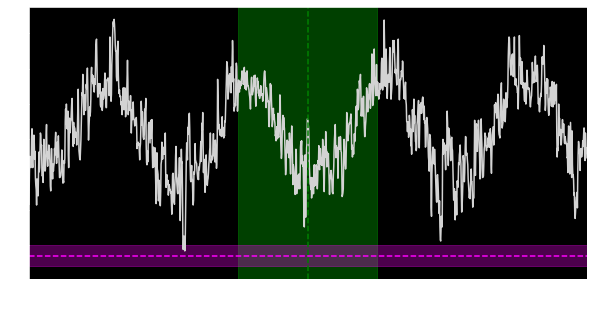

In [11]:
ax = sub['temperature'].plot(color='lightgrey', figsize=(10, 5))
# Add a vertical line
ax.axvline('2022-01-01', color='green', linestyle='--')
# Add a horizontal line
ax.axhline(-6.5, color='magenta', linestyle='--')

# Add a vertical green shaded region
ax.axvspan('2021-07-01', '2022-07-01', color='green', alpha=0.5)

# Add a horizontal magenta shaded region
ax.axhspan(-5, -8, color='magenta', alpha=0.3)

plt.savefig('weather_span.png')

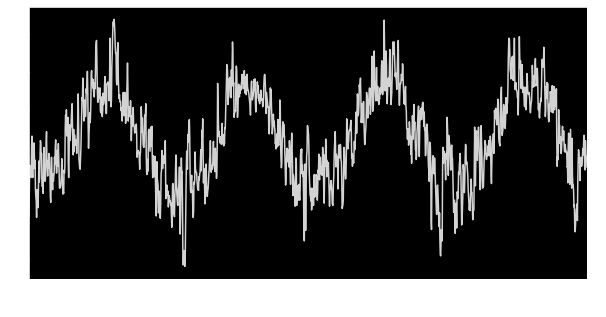

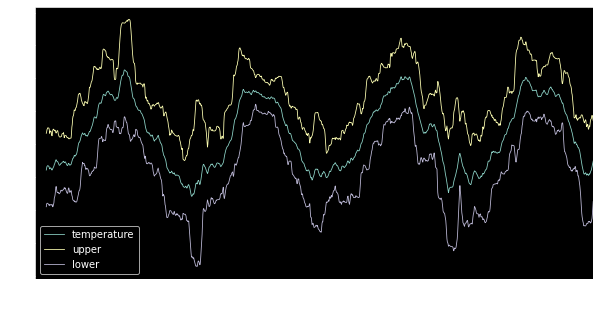

In [12]:
ax = sub['temperature'].plot(color='lightgrey', figsize=(10, 5))
# Compute n days rolling mean
rmw = sub.rolling(window=30).mean()

# Compute n days rolling stdev
rsw = sub.rolling(window=30).std()

# Add the upper bound column rmw DataFrame
rmw['upper'] = rmw['temperature'] + (rsw['temperature'] * 2)

# Add the lower bound column rmw DataFrame
rmw['lower'] = rmw['temperature'] - (rsw['temperature'] * 2)

# Plot the content of the ma DataFrame
ax = rmw[['temperature','upper', 'lower']].plot(linewidth=0.8, figsize=(10, 5))

plt.savefig('weather_rolling.png')

In [13]:
from bokeh.models import DatetimeTickFormatter
from bokeh.plotting import figure, show
from bokeh.sampledata.glucose import data

#reduce data size
data = data.loc['2010-10-06':'2010-10-13'].reset_index()

p = figure(x_axis_type="datetime", background_fill_color='black')
p.line("datetime", "glucose", source=data, color="cyan", legend_label="glucose")

p.title.text = "Glucose Range"
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=0.5
p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Value'
p.legend.level = "overlay"
p.legend.location = "top_left"

# Formatting x-axis tick labels
p.xaxis.formatter = DatetimeTickFormatter(days="%d %b %Y")


show(p)